In [1]:
conda env list

# conda environments:
#
deeplearning-cuda11_8  *  /home/hangdeng/.conda/envs/deeplearning-cuda11_8
torch_tf_exp             /home/hangdeng/.conda/envs/torch_tf_exp
                         /home/hangdeng/projects/Hang/miniconda3_explorer
base                     /shared/centos7/anaconda3/2022.05
CPS_2023_02              /shared/centos7/anaconda3/2022.05/envs/CPS_2023_02
CS_7150_2022             /shared/centos7/anaconda3/2022.05/envs/CS_7150_2022
cs6140_pytorch_env       /shared/centos7/anaconda3/2022.05/envs/cs6140_pytorch_env
ds2000_v2_env            /shared/centos7/anaconda3/2022.05/envs/ds2000_v2_env
fina6333_env             /shared/centos7/anaconda3/2022.05/envs/fina6333_env
tf-horovod               /shared/centos7/anaconda3/2022.05/envs/tf-horovod


Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

In [3]:
import parameters
from U_test import *
import torch
import torch.nn as nn
import numpy as np
import scipy
import torch
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

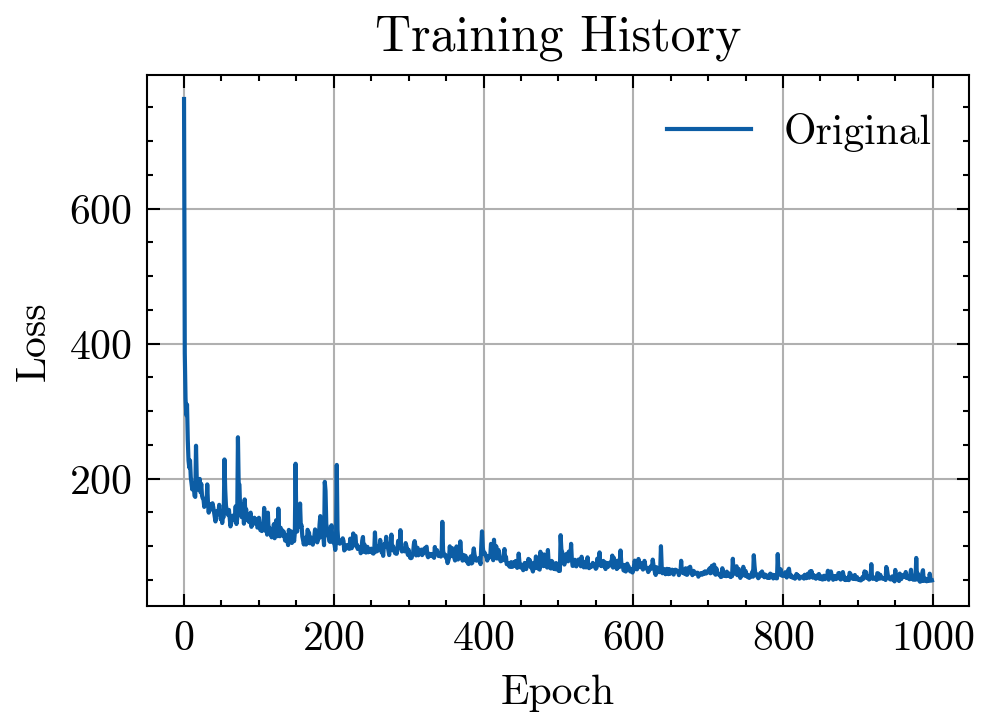

In [4]:
save_folder = 'U_intensity_att1_0625/'
plt.style.use(['science','no-latex'])
plt.figure(dpi=300)
history = pd.DataFrame(pd.read_pickle(save_folder + "training_history.pkl")).T
plt.plot(history['loss'], label='Original')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.tight_layout()
plt.savefig(save_folder + "training_history_compare.png")
plt.show()

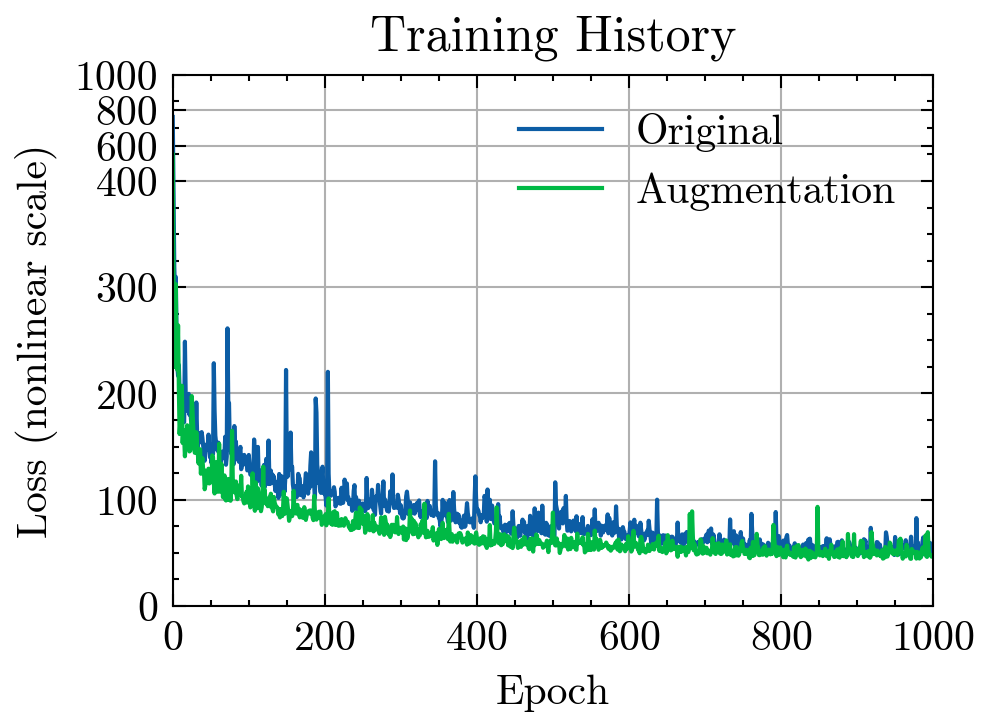

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def nonlinear_y(y):
    y = np.asarray(y)
    return np.where(y <= 400, y * 0.002, 0.8 + (y - 400) * 0.0003333)

plt.style.use(['science','no-latex'])
plt.figure(dpi=300)


# Original
history = pd.DataFrame(pd.read_pickle('U_intensity_att1_0625/training_history.pkl')).T
plt.plot(nonlinear_y(history['loss']), label='Original')

# Augmented
history = pd.DataFrame(pd.read_pickle('U_intensity_att1_k4/training_history.pkl')).T
plt.plot(nonlinear_y(history['loss']), label='Augmentation')


plt.xlabel('Epoch')
plt.ylabel('Loss (nonlinear scale)')
plt.xlim(0, 1000)

# Custom y-ticks (e.g. real loss values)
yticks_real = [0, 100, 200, 300, 400, 600, 800, 1000]
yticks_plot = nonlinear_y(yticks_real)
plt.yticks(yticks_plot, yticks_real)

plt.legend()
plt.title('Training History')
plt.grid(True)
plt.tight_layout()
plt.savefig('U_intensity_att1_0625/training_history_compare.png')
plt.show()

## Load model and best weights

In [6]:
save_folder = 'U_intensity_att1_0625/'
model = UNet(parameters.enc_chs,    parameters.enc_ker,
             parameters.dec_chs,    parameters.dec_ker,
             parameters.cb_chs,     parameters.cb_ker,
             parameters.out_sz,     transform_aug = parameters.transform_aug)
model.load_state_dict((torch.load(save_folder +'/loss.pth',map_location=torch.device('cpu')))['model_state_dict'])
torch.load(save_folder +'/loss.pth', map_location=torch.device('cpu'))['epoch']

983

## Plot model structure

In [9]:
from torchinfo import summary
model = UNet(parameters.enc_chs, parameters.enc_ker,
             parameters.dec_chs, parameters.dec_ker,
             parameters.cb_chs, parameters.cb_ker,
             parameters.out_sz, transform_aug=False)

input_size = (1, 1, 64, 64, 64)  # e.g., (1, 32, 32, 1, 8) in NCDHW
summary(model, input_size=input_size, verbose=2)

0 decode torch.Size([1, 2048, 8, 8, 8])
0 before upconvs torch.Size([1, 256, 8, 8, 8])
0 before torch.Size([1, 512, 16, 16, 16]) torch.Size([1, 2048, 16, 16, 16])
0 cat torch.Size([1, 2560, 16, 16, 16])
1 decode torch.Size([1, 2560, 16, 16, 16])
1 before upconvs torch.Size([1, 128, 16, 16, 16])
1 before torch.Size([1, 256, 32, 32, 32]) torch.Size([1, 512, 32, 32, 32])
1 cat torch.Size([1, 768, 32, 32, 32])
2 decode torch.Size([1, 768, 32, 32, 32])
2 before upconvs torch.Size([1, 128, 32, 32, 32])
2 before torch.Size([1, 256, 64, 64, 64]) torch.Size([1, 128, 64, 64, 64])
2 cat torch.Size([1, 384, 64, 64, 64])
Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 64, 64, 64]        4,720
├─EncoderBlock: 1-1                           [1, 128, 64, 64, 64]      --
│    └─enc_blocks.0.conv1.weight                                        ├─1,600
│    └─enc_blocks.0.conv1.bias                                         

Layer (type:depth-idx)                        Output Shape              Param #
UNet                                          [1, 1, 64, 64, 64]        4,720
├─EncoderBlock: 1-1                           [1, 128, 64, 64, 64]      --
│    └─enc_blocks.0.conv1.weight                                        ├─1,600
│    └─enc_blocks.0.conv1.bias                                          ├─64
│    └─enc_blocks.0.conv2.weight                                        ├─204,800
│    └─enc_blocks.0.conv2.bias                                          ├─128
│    └─enc_blocks.1.conv1.weight                                        ├─294,912
│    └─enc_blocks.1.conv1.bias                                          ├─256
│    └─enc_blocks.1.conv2.weight                                        ├─1,179,648
│    └─enc_blocks.1.conv2.bias                                          ├─512
│    └─enc_blocks.2.conv1.weight                                        ├─524,288
│    └─enc_blocks.2.conv1.bias                

## Do prediction on the whole stack
1. takes 163.49s/stack on cpu, float32
2. pad the D,H,W to be divided by 4
3. seem to have many FP on high intensity area on the original image prediction
4. using norm + reflect_padding has less false positives

In [53]:
import torch
import torch.nn.functional as F
import load_image
import time
import matplotlib.pyplot as plt
import scipy.io
from csbdeep.utils import normalize
from sklearn.cluster import DBSCAN
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
def load_img_tensor(file_name):
    original_img = scipy.io.loadmat(file_name)['Im']
    x = torch.from_numpy(np.transpose(original_img, (2, 1, 0))).to(torch.float32).unsqueeze(0).unsqueeze(0) 
    return x

def get_pad_to_multiple(x, multiple=16):
    _, _, D, H, W = x.shape
    pad_D = (math.ceil(D / multiple) * multiple) - D
    pad_H = (math.ceil(H / multiple) * multiple) - H
    pad_W = (math.ceil(W / multiple) * multiple) - W

    
    # F.pad expects (W_left, W_right, H_left, H_right, D_left, D_right)
    pad = (
        pad_W // 2, pad_W - pad_W // 2,
        pad_H // 2, pad_H - pad_H // 2,
        pad_D // 2, pad_D - pad_D // 2
    )
    return pad



def load_img_norm_tensor(file_name):
    original_img = scipy.io.loadmat(file_name)['Im']

    
    # [pmin, pmax] = [0, 103]
    # img_norm = np.clip(original_img, pmin, pmax) / (pmax - pmin)
    img_norm = normalize(original_img, pmin=0, pmax=99.8, clip=True)

    x = torch.from_numpy(np.transpose(img_norm, (2, 1, 0))).to(torch.float32).unsqueeze(0).unsqueeze(0) 
    return x


def model_prediction_rot(file_name,k, zoom):
    x_norm = load_img_norm_tensor(file_name)
    if zoom!=1:
        size_orig = tuple(int(s) for s in x_norm.shape[-3:])
        size = tuple(int(s) for s in [size_orig[0], size_orig[1] * zoom, size_orig[2] *zoom])
        x_norm = F.interpolate(x_norm, size=size_orig, mode='trilinear', align_corners=False)
    x_norm = torch.rot90(x_norm, k=k, dims=[-2, -1])
    pad_size = get_pad_to_multiple(x_norm, multiple=16)
    
    # padded = F.pad(x_norm, pad_size, mode='reflect')
    Wl, Wr, Hl, Hr, Dl, Dr = pad_size
    yhat_norm = model(F.pad(x_norm, pad_size, mode='reflect'))[:, :, Dl:-Dr if Dr != 0 else None,
                               Hl:-Hr if Hr != 0 else None,
                               Wl:-Wr if Wr != 0 else None]
    yhat_norm = torch.rot90(yhat_norm, k=k, dims=[-1, -2])   

    if zoom!=1:
        yhat_norm = F.interpolate(yhat_norm, size=(60, 512,512), mode='trilinear', align_corners=False)
    return yhat_norm



def get_centroids(norm_yhat, threshold):
    points = np.column_stack(np.where(norm_yhat > threshold))
    clustering = DBSCAN(eps=5, min_samples=1).fit(points) #sets the maximum distance eps=5
    labels = clustering.labels_
    
    # exclude noise (label == -1), get centroids
    centroids = []
    for label in np.unique(labels):
        if label == -1:
            continue  # skip noise
        cluster_points = points[labels == label]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
    
    centroids = np.array(centroids)
    print("convert original", len(points), "of points into", len(centroids), "cluster of centroids")

    return centroids




def compute_metrics(pred_coords, gt_coords, out_coords=False):
    """
    Compute precision, recall, and F1 score based on predicted and ground truth coordinates.
    
    Args:
        pred_coords (np.ndarray): Predicted coordinates of shape (N, 3).
        gt_coords (np.ndarray): Ground truth coordinates of shape (M, 3).
        
    Returns:
        tuple: (TP, FP, FN, precision, recall, f1_score)
    """
    if len(pred_coords) == 0 or len(gt_coords) == 0:
        return 0, len(pred_coords), len(gt_coords), 0.0, 0.0, 0.0
    # Compute pairwise distances
    else:
        threshold = 5
        D = cdist(pred_coords, gt_coords)
        D[D > threshold] = 1e9  # mask distances beyond threshold
        row_ind, col_ind = linear_sum_assignment(D)
        valid = D[row_ind, col_ind] < threshold
        TP = np.sum(valid)
        FP = len(pred_coords) - TP
        FN = len(gt_coords) - TP

        if TP>0:
            matched_pred = pred_coords[row_ind[valid]]
            matched_gt = gt_coords[col_ind[valid]]
            unmatched_pred = pred_coords[row_ind[~valid]]
            unmatched_gt = gt_coords[col_ind[~valid]]
            TP = len(matched_pred)
            FP = len(pred_coords) - len(matched_pred)
            FN = len(gt_coords) - TP
            precision = TP / (TP + FP) 
            recall = TP / (TP + FN)
            f1_score = 2 * (precision * recall) / (precision + recall)
            print(f"TP: {TP}, FP: {FP}, FN: {FN}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1_score:.3f}")
            if out_coords:
                return matched_pred, unmatched_pred, unmatched_gt, matched_gt
            else:
                return precision, recall

        else:
            return 0,0

In [36]:
file_name = '/work/venkatachalamlab/Hang/Transformer/Original_image/Input/img_sub1_1.mat'
output_folder = 'outputs_norm/'
yhat_norm = 0
k_num = 4
for k in tqdm(range(k_num)):
    yhat_norm = model_prediction_rot(file_name,k,zoom=0.5)
    torch.save(yhat_norm, output_folder+ str(k)+'.pt')
    del yhat_norm
    print(k)
# yhat_norm = yhat_norm/k_num

 25%|██▌       | 1/4 [02:02<06:08, 122.72s/it]

0


 50%|█████     | 2/4 [03:58<03:57, 118.55s/it]

1


 75%|███████▌  | 3/4 [05:51<01:55, 115.93s/it]

2


100%|██████████| 4/4 [07:45<00:00, 116.43s/it]

3


In [37]:
file_name = '/work/venkatachalamlab/Hang/Transformer/Original_image/Input/img_sub1_1.mat'
gt_name = '/work/venkatachalamlab/Hang/Transformer/Original_image/Branch/heatmap_sub1_1.mat'
gt_img = scipy.io.loadmat(gt_name)['BT']
gt_coords = np.column_stack(np.where(gt_img > 1800))
original_img = scipy.io.loadmat(file_name)['Im']

In [67]:
output_folder = 'outputs_norm/'

## get the centroid, size, intensity

convert original 438 of points into 113 cluster of centroids
TP: 95, FP: 18, FN: 23, Precision: 0.841, Recall: 0.805, F1 Score: 0.823


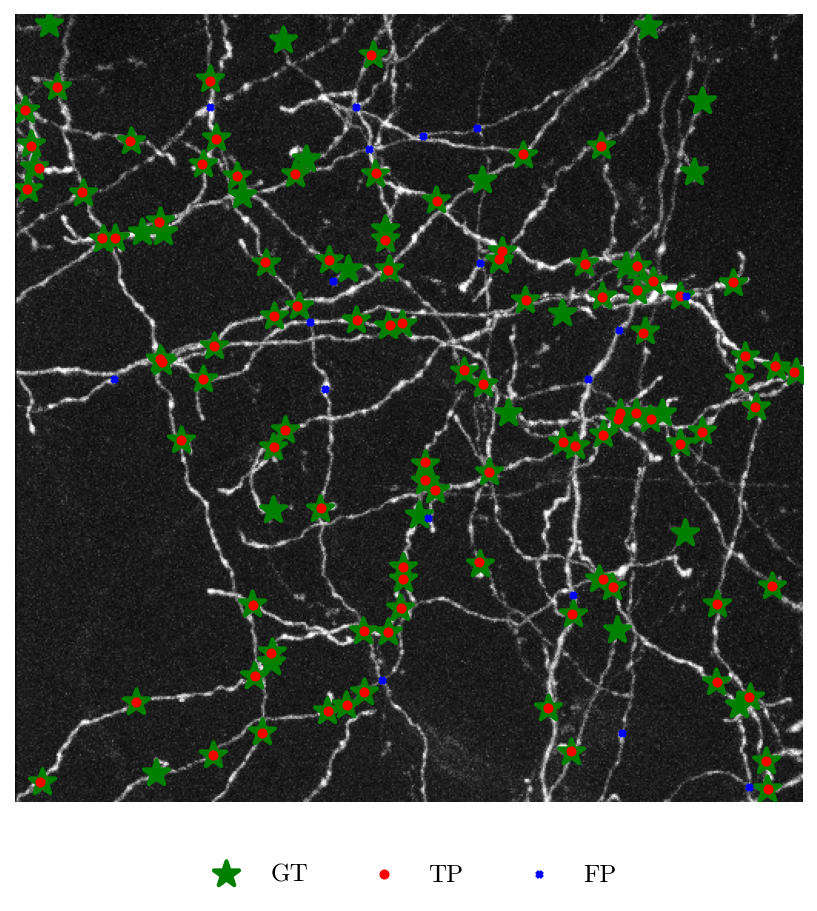

TP: 95, FP: 18, FN: 23, Precision: 0.841, Recall: 0.805, F1 Score: 0.823


In [76]:
yhat_norm = 0
for k in range(4):
    yhat_norm += torch.load(output_folder+ str(k)+'.pt')


yhat_norm += torch.load(output_folder+ str(0)+'.pt')
merged_points = pd.read_csv('outputs/merged_points.csv')[['axis-0', 'axis-1', 'axis-2']].values
norm_yhat = np.transpose(yhat_norm[0,0].detach().numpy(),(2,1,0))
centroids = get_centroids(norm_yhat/5, threshold=62)
matched_pred, unmatched_pred, unmatched_gt, matched_gt = compute_metrics(centroids, merged_points, out_coords=True)

plt.style.use(['science', 'no-latex'])
plt.figure(dpi=300)
plt.imshow(original_img.max(2), cmap='gray')
plt.scatter(merged_points[:, 1], merged_points[:, 0], color='green', marker='*', s=40, label='GT')
plt.scatter(matched_pred[:, 1], matched_pred[:, 0], color='red', marker='o', s=2, label='TP')
plt.scatter(unmatched_pred[:, 1], unmatched_pred[:, 0], color='blue', marker='x', s=2, label='FP')
plt.axis('off')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=6)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.savefig(save_folder + "prediction_proj.png")
# plt.tight_layout()
plt.show()

_ = compute_metrics(centroids, merged_points)


In [77]:
pr_curve = []
for threshold in tqdm(np.arange(10,200,2)): #0625
# for threshold in tqdm(np.arange(1,71,10)): #k4
    centroids = get_centroids(norm_yhat/5, threshold=threshold)
    precision, recall = compute_metrics(centroids, merged_points)
    if precision>0 and recall>0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    pr_curve.append([threshold, precision, recall, f1_score])
pr_curve = np.array(pr_curve)


  2%|▏         | 2/95 [00:00<00:15,  6.09it/s]

convert original 2200 of points into 309 cluster of centroids
TP: 111, FP: 198, FN: 7, Precision: 0.359, Recall: 0.941, F1 Score: 0.520
convert original 2032 of points into 284 cluster of centroids
TP: 110, FP: 174, FN: 8, Precision: 0.387, Recall: 0.932, F1 Score: 0.547


  4%|▍         | 4/95 [00:00<00:13,  6.68it/s]

convert original 1882 of points into 276 cluster of centroids
TP: 110, FP: 166, FN: 8, Precision: 0.399, Recall: 0.932, F1 Score: 0.558
convert original 1758 of points into 269 cluster of centroids
TP: 111, FP: 158, FN: 7, Precision: 0.413, Recall: 0.941, F1 Score: 0.574


  6%|▋         | 6/95 [00:00<00:13,  6.61it/s]

convert original 1650 of points into 254 cluster of centroids
TP: 111, FP: 143, FN: 7, Precision: 0.437, Recall: 0.941, F1 Score: 0.597
convert original 1545 of points into 248 cluster of centroids
TP: 110, FP: 138, FN: 8, Precision: 0.444, Recall: 0.932, F1 Score: 0.601


  8%|▊         | 8/95 [00:01<00:12,  6.92it/s]

convert original 1439 of points into 239 cluster of centroids
TP: 110, FP: 129, FN: 8, Precision: 0.460, Recall: 0.932, F1 Score: 0.616
convert original 1365 of points into 233 cluster of centroids
TP: 110, FP: 123, FN: 8, Precision: 0.472, Recall: 0.932, F1 Score: 0.627


 11%|█         | 10/95 [00:01<00:12,  7.07it/s]

convert original 1292 of points into 227 cluster of centroids
TP: 110, FP: 117, FN: 8, Precision: 0.485, Recall: 0.932, F1 Score: 0.638
convert original 1219 of points into 213 cluster of centroids
TP: 112, FP: 101, FN: 6, Precision: 0.526, Recall: 0.949, F1 Score: 0.677


 13%|█▎        | 12/95 [00:01<00:11,  7.18it/s]

convert original 1129 of points into 209 cluster of centroids
TP: 111, FP: 98, FN: 7, Precision: 0.531, Recall: 0.941, F1 Score: 0.679
convert original 1069 of points into 204 cluster of centroids
TP: 111, FP: 93, FN: 7, Precision: 0.544, Recall: 0.941, F1 Score: 0.689


 15%|█▍        | 14/95 [00:02<00:11,  7.25it/s]

convert original 1007 of points into 195 cluster of centroids
TP: 110, FP: 85, FN: 8, Precision: 0.564, Recall: 0.932, F1 Score: 0.703
convert original 941 of points into 189 cluster of centroids
TP: 109, FP: 80, FN: 9, Precision: 0.577, Recall: 0.924, F1 Score: 0.710


 17%|█▋        | 16/95 [00:02<00:10,  7.28it/s]

convert original 899 of points into 183 cluster of centroids
TP: 109, FP: 74, FN: 9, Precision: 0.596, Recall: 0.924, F1 Score: 0.724
convert original 844 of points into 175 cluster of centroids
TP: 108, FP: 67, FN: 10, Precision: 0.617, Recall: 0.915, F1 Score: 0.737


 19%|█▉        | 18/95 [00:02<00:10,  7.28it/s]

convert original 789 of points into 170 cluster of centroids
TP: 108, FP: 62, FN: 10, Precision: 0.635, Recall: 0.915, F1 Score: 0.750
convert original 753 of points into 163 cluster of centroids
TP: 107, FP: 56, FN: 11, Precision: 0.656, Recall: 0.907, F1 Score: 0.762


 21%|██        | 20/95 [00:02<00:10,  7.30it/s]

convert original 717 of points into 156 cluster of centroids
TP: 107, FP: 49, FN: 11, Precision: 0.686, Recall: 0.907, F1 Score: 0.781
convert original 675 of points into 145 cluster of centroids
TP: 105, FP: 40, FN: 13, Precision: 0.724, Recall: 0.890, F1 Score: 0.798


 23%|██▎       | 22/95 [00:03<00:09,  7.39it/s]

convert original 636 of points into 140 cluster of centroids
TP: 105, FP: 35, FN: 13, Precision: 0.750, Recall: 0.890, F1 Score: 0.814
convert original 593 of points into 136 cluster of centroids
TP: 105, FP: 31, FN: 13, Precision: 0.772, Recall: 0.890, F1 Score: 0.827


 25%|██▌       | 24/95 [00:03<00:09,  7.42it/s]

convert original 564 of points into 135 cluster of centroids
TP: 104, FP: 31, FN: 14, Precision: 0.770, Recall: 0.881, F1 Score: 0.822
convert original 542 of points into 132 cluster of centroids
TP: 102, FP: 30, FN: 16, Precision: 0.773, Recall: 0.864, F1 Score: 0.816


 27%|██▋       | 26/95 [00:03<00:09,  7.38it/s]

convert original 506 of points into 128 cluster of centroids
TP: 101, FP: 27, FN: 17, Precision: 0.789, Recall: 0.856, F1 Score: 0.821
convert original 465 of points into 119 cluster of centroids
TP: 98, FP: 21, FN: 20, Precision: 0.824, Recall: 0.831, F1 Score: 0.827


 29%|██▉       | 28/95 [00:03<00:09,  7.42it/s]

convert original 438 of points into 113 cluster of centroids
TP: 95, FP: 18, FN: 23, Precision: 0.841, Recall: 0.805, F1 Score: 0.823
convert original 409 of points into 109 cluster of centroids
TP: 92, FP: 17, FN: 26, Precision: 0.844, Recall: 0.780, F1 Score: 0.811


 32%|███▏      | 30/95 [00:04<00:08,  7.42it/s]

convert original 388 of points into 106 cluster of centroids
TP: 89, FP: 17, FN: 29, Precision: 0.840, Recall: 0.754, F1 Score: 0.795
convert original 369 of points into 103 cluster of centroids
TP: 87, FP: 16, FN: 31, Precision: 0.845, Recall: 0.737, F1 Score: 0.787


 34%|███▎      | 32/95 [00:04<00:08,  7.43it/s]

convert original 344 of points into 97 cluster of centroids
TP: 83, FP: 14, FN: 35, Precision: 0.856, Recall: 0.703, F1 Score: 0.772
convert original 335 of points into 97 cluster of centroids
TP: 83, FP: 14, FN: 35, Precision: 0.856, Recall: 0.703, F1 Score: 0.772


 36%|███▌      | 34/95 [00:04<00:08,  7.53it/s]

convert original 329 of points into 95 cluster of centroids
TP: 81, FP: 14, FN: 37, Precision: 0.853, Recall: 0.686, F1 Score: 0.761
convert original 312 of points into 91 cluster of centroids
TP: 78, FP: 13, FN: 40, Precision: 0.857, Recall: 0.661, F1 Score: 0.746


 38%|███▊      | 36/95 [00:04<00:07,  7.53it/s]

convert original 300 of points into 90 cluster of centroids
TP: 77, FP: 13, FN: 41, Precision: 0.856, Recall: 0.653, F1 Score: 0.740
convert original 280 of points into 85 cluster of centroids
TP: 73, FP: 12, FN: 45, Precision: 0.859, Recall: 0.619, F1 Score: 0.719


 40%|████      | 38/95 [00:05<00:07,  7.56it/s]

convert original 265 of points into 83 cluster of centroids
TP: 71, FP: 12, FN: 47, Precision: 0.855, Recall: 0.602, F1 Score: 0.706
convert original 254 of points into 82 cluster of centroids
TP: 70, FP: 12, FN: 48, Precision: 0.854, Recall: 0.593, F1 Score: 0.700


 42%|████▏     | 40/95 [00:05<00:07,  7.51it/s]

convert original 244 of points into 80 cluster of centroids
TP: 68, FP: 12, FN: 50, Precision: 0.850, Recall: 0.576, F1 Score: 0.687
convert original 231 of points into 75 cluster of centroids
TP: 63, FP: 12, FN: 55, Precision: 0.840, Recall: 0.534, F1 Score: 0.653


 44%|████▍     | 42/95 [00:05<00:07,  7.56it/s]

convert original 222 of points into 72 cluster of centroids
TP: 61, FP: 11, FN: 57, Precision: 0.847, Recall: 0.517, F1 Score: 0.642
convert original 209 of points into 71 cluster of centroids
TP: 60, FP: 11, FN: 58, Precision: 0.845, Recall: 0.508, F1 Score: 0.635


 46%|████▋     | 44/95 [00:06<00:06,  7.57it/s]

convert original 199 of points into 68 cluster of centroids
TP: 57, FP: 11, FN: 61, Precision: 0.838, Recall: 0.483, F1 Score: 0.613
convert original 187 of points into 66 cluster of centroids
TP: 56, FP: 10, FN: 62, Precision: 0.848, Recall: 0.475, F1 Score: 0.609


 48%|████▊     | 46/95 [00:06<00:06,  7.56it/s]

convert original 183 of points into 64 cluster of centroids
TP: 54, FP: 10, FN: 64, Precision: 0.844, Recall: 0.458, F1 Score: 0.593
convert original 177 of points into 64 cluster of centroids
TP: 54, FP: 10, FN: 64, Precision: 0.844, Recall: 0.458, F1 Score: 0.593


 51%|█████     | 48/95 [00:06<00:06,  7.58it/s]

convert original 167 of points into 62 cluster of centroids
TP: 52, FP: 10, FN: 66, Precision: 0.839, Recall: 0.441, F1 Score: 0.578
convert original 150 of points into 57 cluster of centroids
TP: 48, FP: 9, FN: 70, Precision: 0.842, Recall: 0.407, F1 Score: 0.549


 53%|█████▎    | 50/95 [00:06<00:05,  7.55it/s]

convert original 141 of points into 57 cluster of centroids
TP: 48, FP: 9, FN: 70, Precision: 0.842, Recall: 0.407, F1 Score: 0.549
convert original 134 of points into 57 cluster of centroids
TP: 48, FP: 9, FN: 70, Precision: 0.842, Recall: 0.407, F1 Score: 0.549


 55%|█████▍    | 52/95 [00:07<00:05,  7.60it/s]

convert original 124 of points into 54 cluster of centroids
TP: 46, FP: 8, FN: 72, Precision: 0.852, Recall: 0.390, F1 Score: 0.535
convert original 117 of points into 51 cluster of centroids
TP: 43, FP: 8, FN: 75, Precision: 0.843, Recall: 0.364, F1 Score: 0.509


 57%|█████▋    | 54/95 [00:07<00:05,  7.69it/s]

convert original 112 of points into 49 cluster of centroids
TP: 42, FP: 7, FN: 76, Precision: 0.857, Recall: 0.356, F1 Score: 0.503
convert original 111 of points into 49 cluster of centroids
TP: 42, FP: 7, FN: 76, Precision: 0.857, Recall: 0.356, F1 Score: 0.503


 59%|█████▉    | 56/95 [00:07<00:05,  7.73it/s]

convert original 104 of points into 47 cluster of centroids
TP: 40, FP: 7, FN: 78, Precision: 0.851, Recall: 0.339, F1 Score: 0.485
convert original 98 of points into 45 cluster of centroids
TP: 38, FP: 7, FN: 80, Precision: 0.844, Recall: 0.322, F1 Score: 0.466


 61%|██████    | 58/95 [00:07<00:04,  7.71it/s]

convert original 95 of points into 43 cluster of centroids
TP: 37, FP: 6, FN: 81, Precision: 0.860, Recall: 0.314, F1 Score: 0.460
convert original 87 of points into 39 cluster of centroids
TP: 33, FP: 6, FN: 85, Precision: 0.846, Recall: 0.280, F1 Score: 0.420


 63%|██████▎   | 60/95 [00:08<00:04,  7.69it/s]

convert original 83 of points into 37 cluster of centroids
TP: 31, FP: 6, FN: 87, Precision: 0.838, Recall: 0.263, F1 Score: 0.400
convert original 80 of points into 36 cluster of centroids
TP: 30, FP: 6, FN: 88, Precision: 0.833, Recall: 0.254, F1 Score: 0.390


 65%|██████▌   | 62/95 [00:08<00:04,  7.67it/s]

convert original 75 of points into 36 cluster of centroids
TP: 30, FP: 6, FN: 88, Precision: 0.833, Recall: 0.254, F1 Score: 0.390
convert original 74 of points into 36 cluster of centroids
TP: 30, FP: 6, FN: 88, Precision: 0.833, Recall: 0.254, F1 Score: 0.390


 67%|██████▋   | 64/95 [00:08<00:04,  7.59it/s]

convert original 73 of points into 36 cluster of centroids
TP: 30, FP: 6, FN: 88, Precision: 0.833, Recall: 0.254, F1 Score: 0.390
convert original 64 of points into 32 cluster of centroids
TP: 27, FP: 5, FN: 91, Precision: 0.844, Recall: 0.229, F1 Score: 0.360


 69%|██████▉   | 66/95 [00:08<00:03,  7.64it/s]

convert original 62 of points into 32 cluster of centroids
TP: 27, FP: 5, FN: 91, Precision: 0.844, Recall: 0.229, F1 Score: 0.360
convert original 58 of points into 30 cluster of centroids
TP: 25, FP: 5, FN: 93, Precision: 0.833, Recall: 0.212, F1 Score: 0.338


 72%|███████▏  | 68/95 [00:09<00:03,  7.64it/s]

convert original 53 of points into 28 cluster of centroids
TP: 23, FP: 5, FN: 95, Precision: 0.821, Recall: 0.195, F1 Score: 0.315
convert original 50 of points into 28 cluster of centroids
TP: 23, FP: 5, FN: 95, Precision: 0.821, Recall: 0.195, F1 Score: 0.315


 74%|███████▎  | 70/95 [00:09<00:03,  7.65it/s]

convert original 46 of points into 27 cluster of centroids
TP: 22, FP: 5, FN: 96, Precision: 0.815, Recall: 0.186, F1 Score: 0.303
convert original 45 of points into 27 cluster of centroids
TP: 22, FP: 5, FN: 96, Precision: 0.815, Recall: 0.186, F1 Score: 0.303


 76%|███████▌  | 72/95 [00:09<00:02,  7.72it/s]

convert original 42 of points into 26 cluster of centroids
TP: 21, FP: 5, FN: 97, Precision: 0.808, Recall: 0.178, F1 Score: 0.292
convert original 39 of points into 25 cluster of centroids
TP: 20, FP: 5, FN: 98, Precision: 0.800, Recall: 0.169, F1 Score: 0.280


 78%|███████▊  | 74/95 [00:09<00:02,  7.71it/s]

convert original 36 of points into 23 cluster of centroids
TP: 18, FP: 5, FN: 100, Precision: 0.783, Recall: 0.153, F1 Score: 0.255
convert original 35 of points into 22 cluster of centroids
TP: 18, FP: 4, FN: 100, Precision: 0.818, Recall: 0.153, F1 Score: 0.257


 80%|████████  | 76/95 [00:10<00:02,  7.78it/s]

convert original 33 of points into 21 cluster of centroids
TP: 17, FP: 4, FN: 101, Precision: 0.810, Recall: 0.144, F1 Score: 0.245
convert original 33 of points into 21 cluster of centroids
TP: 17, FP: 4, FN: 101, Precision: 0.810, Recall: 0.144, F1 Score: 0.245


 82%|████████▏ | 78/95 [00:10<00:02,  7.84it/s]

convert original 32 of points into 21 cluster of centroids
TP: 17, FP: 4, FN: 101, Precision: 0.810, Recall: 0.144, F1 Score: 0.245
convert original 30 of points into 20 cluster of centroids
TP: 16, FP: 4, FN: 102, Precision: 0.800, Recall: 0.136, F1 Score: 0.232


 84%|████████▍ | 80/95 [00:10<00:01,  7.80it/s]

convert original 28 of points into 19 cluster of centroids
TP: 15, FP: 4, FN: 103, Precision: 0.789, Recall: 0.127, F1 Score: 0.219
convert original 28 of points into 19 cluster of centroids
TP: 15, FP: 4, FN: 103, Precision: 0.789, Recall: 0.127, F1 Score: 0.219


 86%|████████▋ | 82/95 [00:10<00:01,  7.77it/s]

convert original 28 of points into 19 cluster of centroids
TP: 15, FP: 4, FN: 103, Precision: 0.789, Recall: 0.127, F1 Score: 0.219
convert original 27 of points into 19 cluster of centroids
TP: 15, FP: 4, FN: 103, Precision: 0.789, Recall: 0.127, F1 Score: 0.219


 88%|████████▊ | 84/95 [00:11<00:01,  7.75it/s]

convert original 25 of points into 19 cluster of centroids
TP: 15, FP: 4, FN: 103, Precision: 0.789, Recall: 0.127, F1 Score: 0.219
convert original 23 of points into 18 cluster of centroids
TP: 15, FP: 3, FN: 103, Precision: 0.833, Recall: 0.127, F1 Score: 0.221


 91%|█████████ | 86/95 [00:11<00:01,  7.75it/s]

convert original 22 of points into 17 cluster of centroids
TP: 14, FP: 3, FN: 104, Precision: 0.824, Recall: 0.119, F1 Score: 0.207
convert original 22 of points into 17 cluster of centroids
TP: 14, FP: 3, FN: 104, Precision: 0.824, Recall: 0.119, F1 Score: 0.207


 93%|█████████▎| 88/95 [00:11<00:00,  7.75it/s]

convert original 22 of points into 17 cluster of centroids
TP: 14, FP: 3, FN: 104, Precision: 0.824, Recall: 0.119, F1 Score: 0.207
convert original 21 of points into 16 cluster of centroids
TP: 13, FP: 3, FN: 105, Precision: 0.812, Recall: 0.110, F1 Score: 0.194


 95%|█████████▍| 90/95 [00:12<00:00,  7.73it/s]

convert original 20 of points into 15 cluster of centroids
TP: 13, FP: 2, FN: 105, Precision: 0.867, Recall: 0.110, F1 Score: 0.195
convert original 18 of points into 14 cluster of centroids
TP: 12, FP: 2, FN: 106, Precision: 0.857, Recall: 0.102, F1 Score: 0.182


 97%|█████████▋| 92/95 [00:12<00:00,  7.77it/s]

convert original 18 of points into 14 cluster of centroids
TP: 12, FP: 2, FN: 106, Precision: 0.857, Recall: 0.102, F1 Score: 0.182
convert original 18 of points into 14 cluster of centroids
TP: 12, FP: 2, FN: 106, Precision: 0.857, Recall: 0.102, F1 Score: 0.182


 99%|█████████▉| 94/95 [00:12<00:00,  7.71it/s]

convert original 17 of points into 14 cluster of centroids
TP: 12, FP: 2, FN: 106, Precision: 0.857, Recall: 0.102, F1 Score: 0.182
convert original 16 of points into 13 cluster of centroids
TP: 11, FP: 2, FN: 107, Precision: 0.846, Recall: 0.093, F1 Score: 0.168


100%|██████████| 95/95 [00:12<00:00,  7.49it/s]

convert original 14 of points into 12 cluster of centroids
TP: 10, FP: 2, FN: 108, Precision: 0.833, Recall: 0.085, F1 Score: 0.154


In [78]:
threshold = 62
centroids = get_centroids(norm_yhat/5, threshold=threshold)
precision, recall = compute_metrics(centroids, merged_points)

convert original 438 of points into 113 cluster of centroids
TP: 95, FP: 18, FN: 23, Precision: 0.841, Recall: 0.805, F1 Score: 0.823


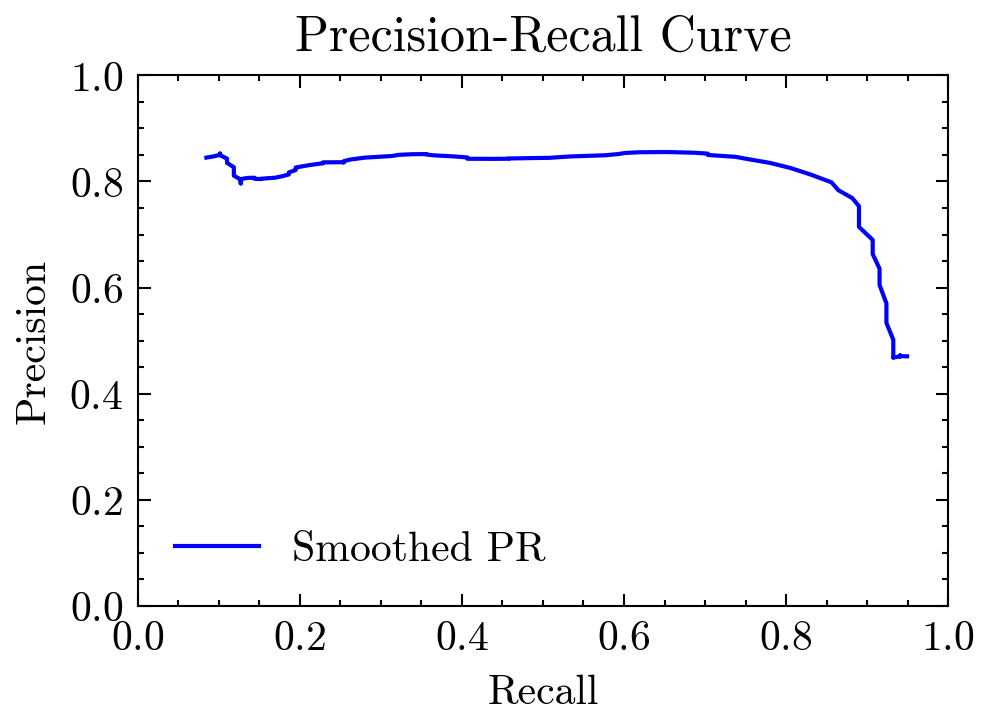

array([[60.        ,  0.82352941,  0.83050847,  0.82700422],
       [62.        ,  0.84070796,  0.80508475,  0.82251082],
       [64.        ,  0.8440367 ,  0.77966102,  0.81057269],
       [66.        ,  0.83962264,  0.75423729,  0.79464286],
       [68.        ,  0.84466019,  0.73728814,  0.78733032],
       [70.        ,  0.8556701 ,  0.70338983,  0.77209302],
       [72.        ,  0.8556701 ,  0.70338983,  0.77209302]])

In [80]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d



recall = pr_curve[:, 2]
precision = pr_curve[:, 1]
sorted_idx = recall.argsort()
recall_sorted = recall[sorted_idx]
precision_sorted = precision[sorted_idx]
# Smooth precision
precision_smooth = gaussian_filter1d(precision_sorted, sigma=2)

plt.style.use(['science', 'no-latex'])
plt.figure(dpi=300)
plt.plot(recall_sorted, precision_smooth, 'b-', label='Smoothed PR')
# plt.plot(recall, precision, '.', label='Original PR')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.savefig(save_folder + "precision_recall.png")
plt.show()

ind = np.logical_and(pr_curve[:,2]>0.7, pr_curve[:,2]<0.85)
pr_curve[ind]

In [8]:
num =64
8*num, 4*num, 40*num, 4*num, 2*num, 12*num, 1*num, 2*num

(512, 256, 2560, 256, 128, 768, 64, 128)